In [1]:
#relevant imports 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import os
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from skimage import io

import torch
from torch import nn
import torchvision
from torchvision import datasets, models, transforms as T
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
import torch.utils.data as data
import torchvision.utils as vutils
from torchinfo import summary
import torch.nn.functional as F




This notebook aims to implement hybrid CNN models for detection of breast cancer as proposed by Sahu et al in their paper *High accuracy hybrid CNN classifiers for breast cancer detection using mammogram and ultrasound datasets*

# Initial Exploratory analysis

In [2]:
fold_info = pd.read_csv("/kaggle/input/breakhis/Folds.csv")
fold_info["label"] = fold_info["filename"].str.extract("(malignant|benign)")
fold_info['label'] = fold_info['label'].map({'malignant': 1, 'benign': 0})
fold_info[1:]

,fold,mag,grp,filename,label
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,0
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,0
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,0
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,0
5,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,0
...,...,...,...,...,...
39540,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,1
39541,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,1
39542,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,1
39543,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,1


For the extent of this implementation, I will be focusing on 2-fold images, and all work would be done on them.

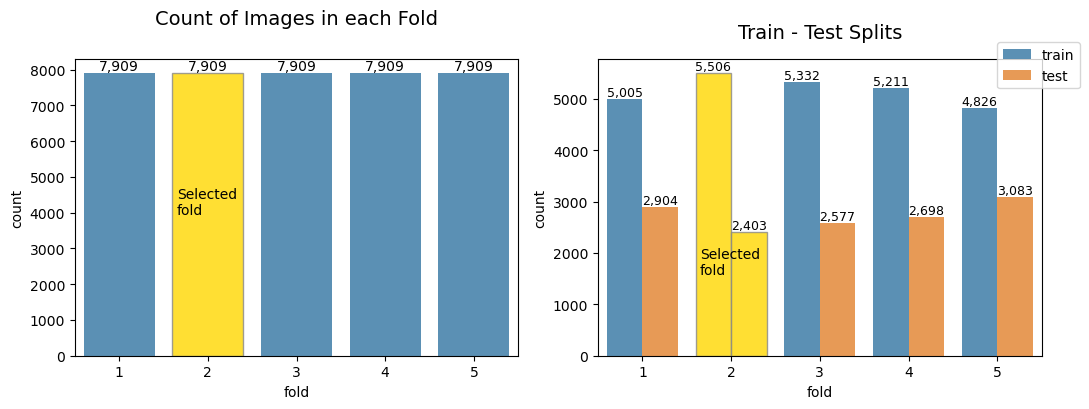

In [3]:
selected_fold = 2
selected_fold_data = fold_info.query("fold == @selected_fold").copy()
selected_fold_data["filename"] = ("/kaggle/input/breakhis/BreaKHis_v1/"
                                  + selected_fold_data["filename"])
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11, 4.2), tight_layout=True)

# Plot image count in each fold
sns.countplot(data=fold_info, x="fold", color="C0", ax=ax1, alpha=0.8)
bars = ax1.containers[0]
ax1.bar_label(bars, padding=0,
             labels=[f"{x:,.0f}" for x in bars.datavalues])
_selected_bar = bars[selected_fold - 1]
_selected_bar.set_facecolor("gold")
_selected_bar.set_edgecolor("#888")
ax1.text(_selected_bar.get_x() + 0.05, _selected_bar.get_height() / 2,
         "Selected\nfold")
ax1.set_title("Count of Images in each Fold", size=14, pad=25)

# Plot train-test split
sns.countplot(data=fold_info, x="fold", hue="grp", palette="tab10",
              ax=ax2, alpha=0.8)
for bars in ax2.containers:
    ax2.bar_label(bars, [f"{x:,.0f}" for x in bars.datavalues], size=9)
    bars[selected_fold - 1].set_facecolor("gold")
    bars[selected_fold - 1].set_edgecolor("#888")
ax2.text(_selected_bar.get_x() + 0.05, _selected_bar.get_height() / 5,
         "Selected\nfold")
ax2.set_title("Train - Test Splits", size=14, pad=15)
ax2.legend(loc=(0.9, 0.9));

In [4]:
selected_fold_data['label'].value_counts()

1    5429
0    2480
Name: label, dtype: int64

In [5]:
train = selected_fold_data.query("grp == 'train'")
test = selected_fold_data.query("grp == 'test'")
train.shape, test.shape

((5506, 5), (2403, 5))

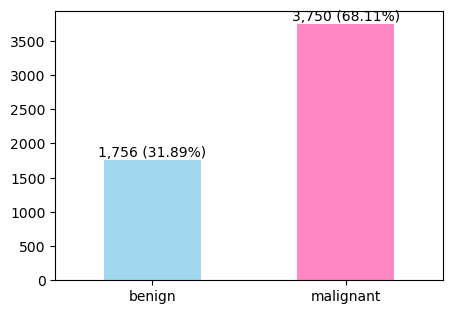

In [6]:
classes = dict(benign=0, malignant=1)
class_names = list(classes.keys())
label_counts = train["label"].value_counts(ascending=True)
ax = label_counts.plot.bar(color=["skyblue", "hotpink"], alpha=0.8,
                           figsize=(5, 3.5))
ax.bar_label(ax.containers[0], padding=0,
             labels=[f"{x:,} ({x/len(train):.2%})" for x in label_counts])
ax.set_xticklabels(["benign", "malignant"], rotation=0);

As we can see that the classes are quite imbalanced. To deal with this, a weighted loss function can be used, but for the scope of this project, I will undersample the dataset, taking 1500 both images from both classes. This will help the model train quicker as well.
Doing so will upset the train-test split. To counter that, we will undersample the test set as well but without touching the class imbalance. This is done to maintain the real-world nature of the data. A split of 75:25 is maintained.

In [7]:
benign_df=train[train["label"]==0]
mal_df=train[train["label"]==1]
benign_sample=benign_df.sample(n=1500, random_state=42)
mal_sample=mal_df.sample(n=1500, random_state=42)
train_balanced=pd.concat([benign_sample, mal_sample])

test_set=test.sample(n=500, random_state=42)
train_balanced.shape, test_set.shape

((3000, 5), (500, 5))

In [8]:
device ='cuda' if torch.cuda.is_available() else 'cpu'

# Handling the data

In [9]:
class CustomDataset(data.Dataset):
    '''
    Implementation of a custom dataset class.
    '''
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __getitem__(self, index):
        filename = self.df.iloc[index]['filename']
        label = self.df.iloc[index]['label']
        img = Image.open(filename).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.df)


In [10]:
MEAN, STD=(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
IMAGE_SIZE=224
BATCH_SIZE=64

In [11]:
data_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.Normalize(MEAN, STD)
    
])

In [12]:
#creating relevant dataloaders

train_dataset = CustomDataset(train_balanced, transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = CustomDataset(test_set, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
next(iter(test_loader))[0].shape

torch.Size([64, 3, 224, 224])

In [14]:
len(train_dataset), len(test_dataset)

(3000, 500)

In [15]:
def plot_images(dataloader, num_images=16):
    """
    function for easy visualisation of images from dataset.
    args:
        dataloader: a pytorch dataloader object
        num_images: number of images to be plotted
    """
    
    # Get a batch of images from the dataloader
    data = next(iter(dataloader))
    images, _ = data

    # Generate a grid of images
    img_grid = vutils.make_grid(images[:num_images], nrow=4, padding=2, normalize=True)

    # Convert the image grid to a numpy array and transpose the dimensions
    img_grid = np.transpose(img_grid.cpu().numpy(), (1, 2, 0))

    # Plot the image grid
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(img_grid)
    plt.title("Sample Images")
    plt.show()


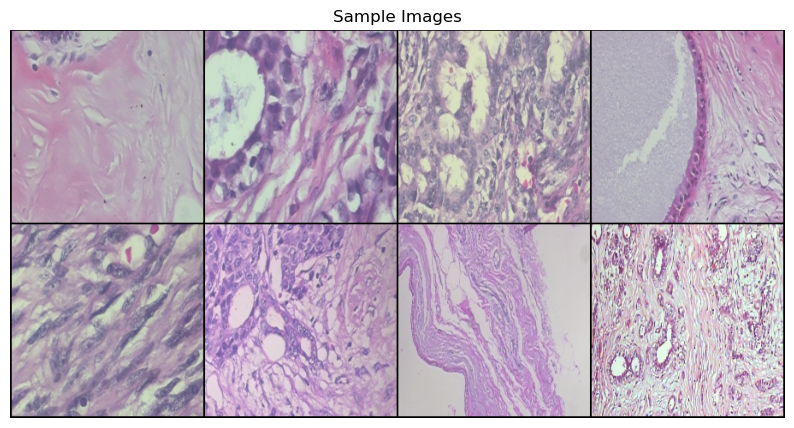

In [16]:
plot_images(train_loader, num_images=8)

In [17]:
class SaveBestModel:
    """ class to save best model while training. """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, loss_fn
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_fn,
                }, '/kaggle/working/best_model.pth')



In [18]:
def save_model(epochs, model, optimizer, loss_fn):
    """
    save final model
    """
    print(f"Saving final model.")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_fn,
                }, '/kaggle/working/final_model.pth')

In [19]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.savefig('/kaggle/working/accuracy.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig('/kaggle/working/loss.png')

# Defining the architecture

In this notebook, I have implemented the Hybrid-5 model as discussed in the paper. This includes a Resnet-18 model as the first model and a ShuffleNet model as the secondary model.

In [20]:
class ResNet18(nn.Module):
    '''
    Class to define a finetuned ResNet18 model. 
    Args:
        num_classes: number of classes
    '''
    def __init__(self, num_classes):
        super().__init__()
        self.resnet18 = models.resnet18('DEFAULT')
        num_ftrs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Sequential(
            nn.Linear(num_ftrs, num_ftrs * 2),
            nn.Linear(num_ftrs * 2, num_classes))

    def forward(self, x):
        return self.resnet18(x)


In [21]:
class ShuffleNet(nn.Module):
    """
    Class to define a finetuned shufflenet model.
    args:
        num_classes: number of classes
    """
    def __init__(self, num_classes):
        super().__init__()
        self.shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
        self.num_classes = num_classes
        self.fc = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        x = self.shufflenet.conv1(x)
        x = self.shufflenet.maxpool(x)
        x = self.shufflenet.stage2(x)
        x = self.shufflenet.stage3(x)
        x = self.shufflenet.stage4(x)
        x = self.shufflenet.conv5(x)
        x = x.mean([2, 3])
        x = self.fc(x)
        return x



In [22]:
B=0.05 #threshold value to determine the activation of second model

def weight_factor(class_prob):
    """
    function to calculate weight factor as defined in the paper.
    args:
        class_prob: pytorch tensor with dims [batch_size, 2]
    """
    p1 = class_prob[:, 0]
    p2 = class_prob[:, 1]
    w = torch.abs(torch.mul(p1, torch.log2(2 * p2)) + torch.mul(p2, torch.log2(2 * p1)))
    return w

# Setting up test and train functions

In [23]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    """
    One epoch of training.
    Args:
        model: the pytorch model to be trained
        dataloader: pytorch DataLoader object to train the model on
        loss_fn: pytorch loss function
        optimizer: pytorch optimizer function to minimise loss
        device: gpu/cpu
    """
 
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [24]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) :
    """
    One epoch of testing.
    Args:
        model: the pytorch model to be tested
        dataloader: pytorch DataLoader object to test the model on
        loss_fn: pytorch loss function
        device: gpu/cpu
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    #Create lists to store indices for subset creation
    selected_batch_indices = []
    selected_sample_indices = []


    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)
            
            #get class probabilities and subsequently weight factor
            class_prob=F.softmax(test_pred_logits, dim=1)
            weights=weight_factor(class_prob)
            

            #store indices of images with weight factor less than threshold to access labels
            selected_sample_indices_batch = [i for i, w in enumerate(weights) if w < B]
            selected_batch_indices += [batch] * len(selected_sample_indices_batch)
            selected_sample_indices += selected_sample_indices_batch

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
    

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    
    #create a subset of the relevant images and add their labels
    selected_indices = [i * BATCH_SIZE + j for i, j in zip(selected_batch_indices, selected_sample_indices)]
    epoch_subset = Subset(test_dataset, selected_indices)
    
    
    return test_loss, test_acc, epoch_subset, weights
    

In [25]:

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) :
    """
    Joint train and test step.
    Args:
        model: the pytorch model to be trained
        train_dataloader: pytorch DataLoader object to train the model on
        test_dataloader: pytorch DataLoader object to test the model on
        loss_fn: pytorch loss function
        optimizer: pytorch optimizer function to minimise loss
        epochs: number of epochs 
        device: gpu/cpu
  
    """
 
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
              }
    
    
    final_subset=[]
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc , epoch_subset, weights= test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} "
    
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
#         results["class_prob"].append(class_prob)
        final_subset=epoch_subset
        save_best_model(test_loss, epoch, model, optimizer, loss_fn)

    save_model(epochs, model,optimizer, loss_fn)
    save_plots(results["train_acc"], results["test_acc"], results["train_loss"], results["test_loss"])

    # Return the filled results and subset at the end of the epochs
    return results, final_subset, weights

# Defining and training models

In [26]:
model1 = ResNet18(num_classes=2)
optimizer=torch.optim.Adam(params=model1.parameters(),
                          lr=0.0001,
                          betas=(0.9, 0.999),
                          weight_decay=0.3)

save_best_model=SaveBestModel()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4962 | train_acc: 0.7717 | test_loss: 0.4201 | test_acc: 0.8187 

Saving best model for epoch: 1

Epoch: 2 | train_loss: 0.2507 | train_acc: 0.9100 | test_loss: 0.3349 | test_acc: 0.8601 

Saving best model for epoch: 2

Epoch: 3 | train_loss: 0.1460 | train_acc: 0.9603 | test_loss: 0.3615 | test_acc: 0.8460 
Epoch: 4 | train_loss: 0.0927 | train_acc: 0.9756 | test_loss: 0.3781 | test_acc: 0.8299 
Epoch: 5 | train_loss: 0.0790 | train_acc: 0.9777 | test_loss: 0.4542 | test_acc: 0.8212 
Epoch: 6 | train_loss: 0.0761 | train_acc: 0.9742 | test_loss: 0.4826 | test_acc: 0.8178 
Epoch: 7 | train_loss: 0.0905 | train_acc: 0.9720 | test_loss: 0.5362 | test_acc: 0.7559 
Epoch: 8 | train_loss: 0.0670 | train_acc: 0.9777 | test_loss: 0.5588 | test_acc: 0.7910 
Epoch: 9 | train_loss: 0.0799 | train_acc: 0.9737 | test_loss: 0.5094 | test_acc: 0.8017 
Epoch: 10 | train_loss: 0.0801 | train_acc: 0.9760 | test_loss: 0.5221 | test_acc: 0.8145 
Epoch: 11 | train_loss: 0.0736 | 

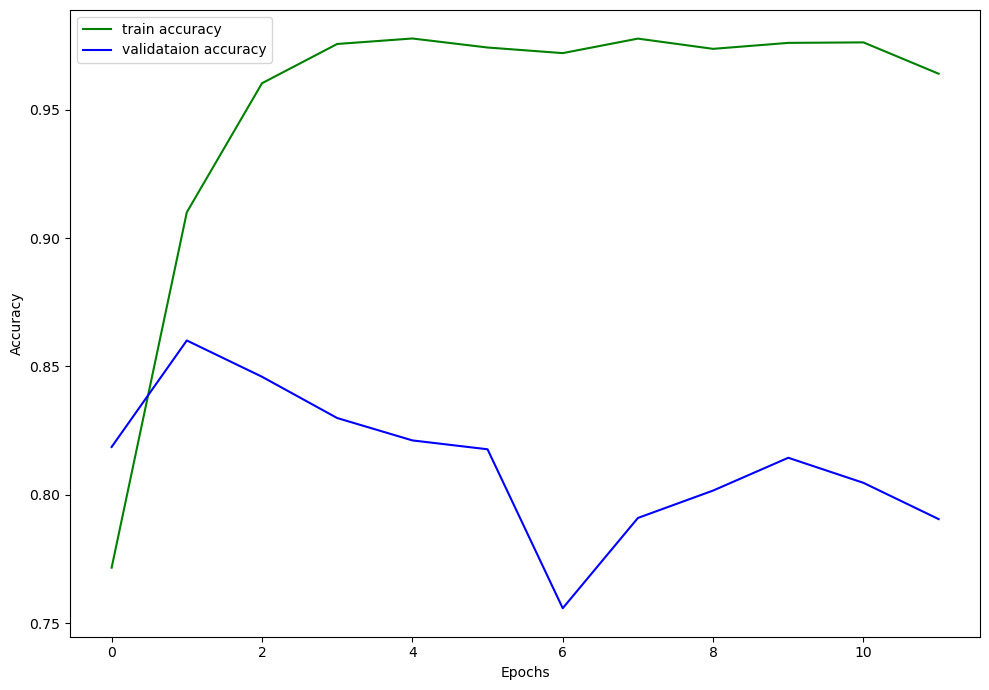

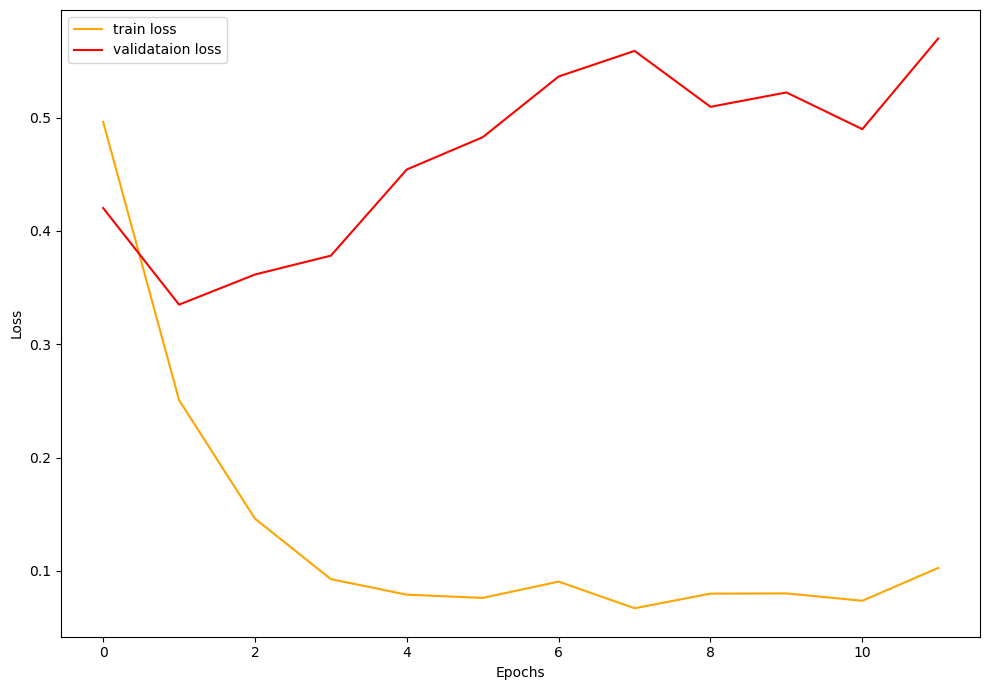

In [27]:
results, final_subset, weights=train(model=model1,
              train_dataloader=train_loader,
              test_dataloader=test_loader,
              optimizer=optimizer,
              loss_fn=F.cross_entropy,
              epochs=12,
              device=device )

final_subset is a subset of the test set whose B value is less than the threshold. These images will be passed on to training from the second model, thus activating the hybrid architecture.
A dataloader is created for final_subset and the second model is tested against it. The training of the secomd model is done on the train_dataset as well.

In [28]:
len(final_subset)

24

In [29]:
hybrid_loader = DataLoader(final_subset, batch_size=BATCH_SIZE, shuffle=False)

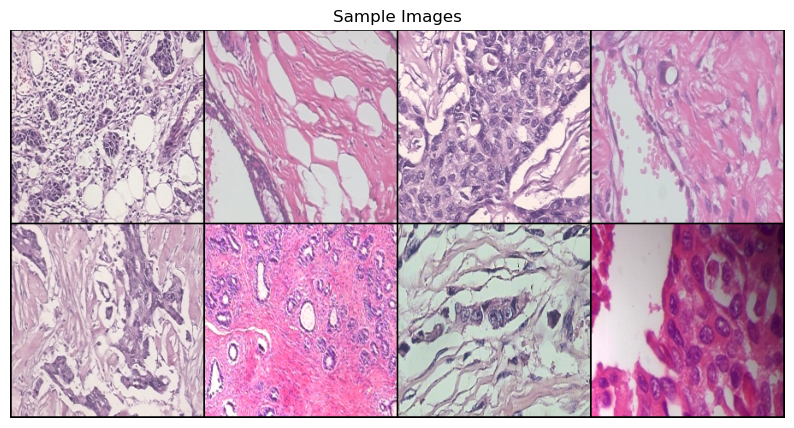

In [30]:
plot_images(hybrid_loader, 8)

#plotting out images from the hybrid_loader

In [31]:
model2 = ShuffleNet(num_classes=2)

#Since the paper only mentioned the optimizer configuration of the first model, I took liberty for the configuration of the second model and used the same optimizer as in the original ShiffleNet paper.

optimizer2=torch.optim.SGD(params=model2.parameters(), 
                          lr=0.0001, 
                          momentum=0.9, 
                          weight_decay=0.0001)

save_best_model=SaveBestModel()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth


  0%|          | 0.00/8.79M [00:00<?, ?B/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6919 | train_acc: 0.5506 | test_loss: 0.6918 | test_acc: 0.6250 

Saving best model for epoch: 1

Epoch: 2 | train_loss: 0.6917 | train_acc: 0.5574 | test_loss: 0.6923 | test_acc: 0.5417 
Epoch: 3 | train_loss: 0.6915 | train_acc: 0.5806 | test_loss: 0.6924 | test_acc: 0.5417 
Epoch: 4 | train_loss: 0.6914 | train_acc: 0.5801 | test_loss: 0.6927 | test_acc: 0.5417 
Epoch: 5 | train_loss: 0.6913 | train_acc: 0.5862 | test_loss: 0.6924 | test_acc: 0.5417 
Epoch: 6 | train_loss: 0.6912 | train_acc: 0.5858 | test_loss: 0.6923 | test_acc: 0.5417 
Epoch: 7 | train_loss: 0.6910 | train_acc: 0.5947 | test_loss: 0.6925 | test_acc: 0.5417 
Epoch: 8 | train_loss: 0.6909 | train_acc: 0.6106 | test_loss: 0.6928 | test_acc: 0.5417 
Epoch: 9 | train_loss: 0.6908 | train_acc: 0.6191 | test_loss: 0.6930 | test_acc: 0.5000 
Epoch: 10 | train_loss: 0.6906 | train_acc: 0.6268 | test_loss: 0.6926 | test_acc: 0.5417 
Epoch: 11 | train_loss: 0.6905 | train_acc: 0.6297 | test_loss: 0.

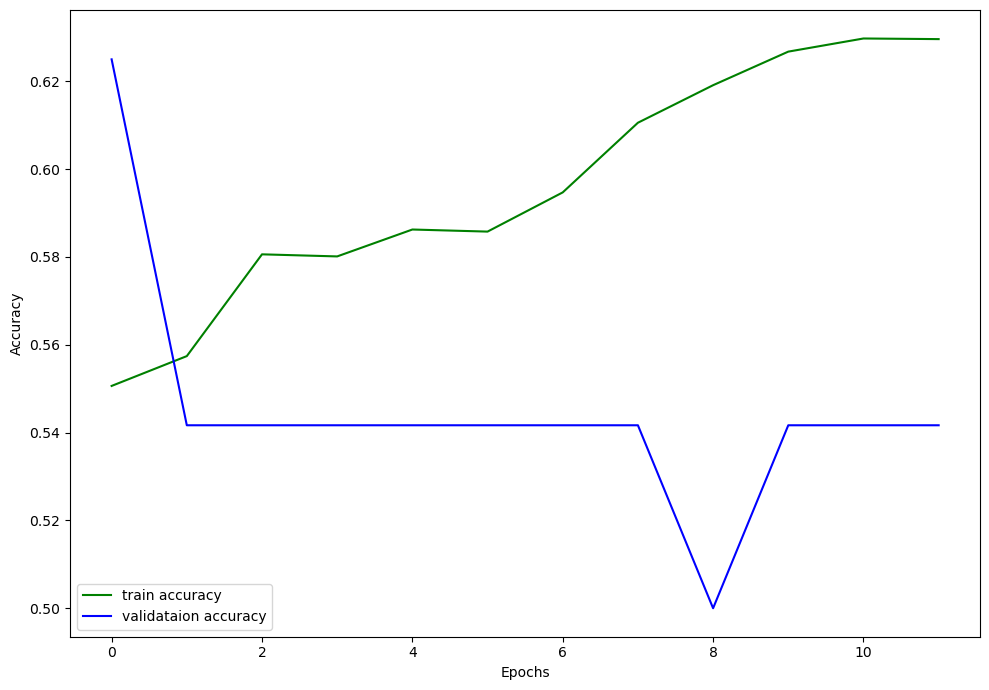

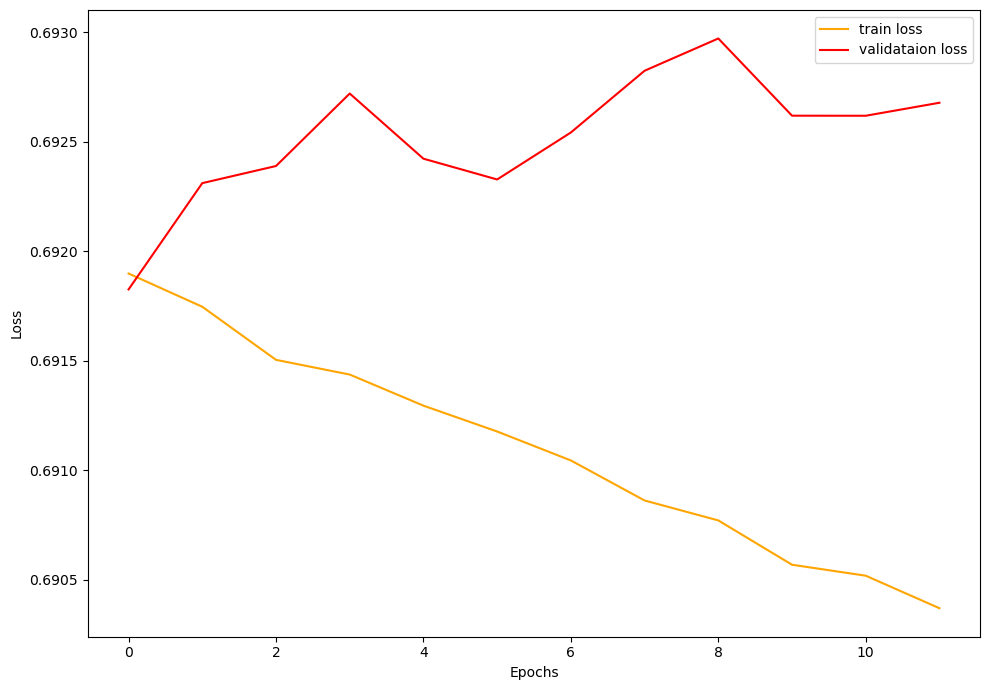

In [32]:
results, final_subset, weights=train(model=model2,
              train_dataloader=train_loader,
              test_dataloader=hybrid_loader,
              optimizer=optimizer2,
              loss_fn=F.cross_entropy,
              epochs=12,
              device=device )

Since the hyperparameters of the second model were not explaiend in the paper, the results obtained in this implementation vary. With sufficient hyperparameter tuning, similar results can be replicated as well.